In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from glob import glob
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from skimage import transform
import itertools as it
from sklearn.neighbors.kde import KernelDensity
import matplotlib.cm as cm
import queue
from skimage import morphology
import dlib
import cv2
from imutils import face_utils
from scipy.spatial import Delaunay

(164, 175, 3)


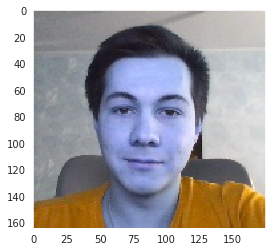

In [2]:
img_input = np.array(Image.open('maxim-min.jpg'))
print(img_input.shape)
plt.imshow(img_input)

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../data/shape_predictor_68_face_landmarks.dat')

img_gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
rects = detector(img_gray, 0)
shape = predictor(img_gray, rects[0])
shape = face_utils.shape_to_np(shape)

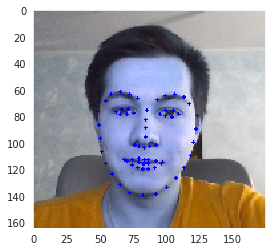

In [4]:
img_tmp = img_input.copy()
for x, y in shape:
    cv2.circle(img_tmp, (x, y), 1, (0, 0, 255), -1)
plt.imshow(img_tmp)

In [5]:
face_origin = sorted([(t.width()*t.height(), 
                       (t.left(), t.top(), t.width(), t.height())) 
                      for t in rects], 
                     key=lambda t: t[0], reverse=True)[0][1]

rescale = (1.3, 2.2, 1.3, 1.3)
(x, y, w, h) = face_origin
cx = x + w/2
cy = y + h/2

w = min(img_input.shape[1] - x, int(w/2 + rescale[2]*w/2))
h = min(img_input.shape[0] - y, int(h/2 + rescale[3]*h/2))

fx = max(0, int(x + w/2*(1 - rescale[0])))
fy = max(0, int(y + h/2*(1 - rescale[1])))
fw = min(img_input.shape[1] - fx, int(w - w/2*(1 - rescale[0])))
fh = min(img_input.shape[0] - fy, int(h - h/2*(1 - rescale[1])))

face = (fx, fy, fw, fh)

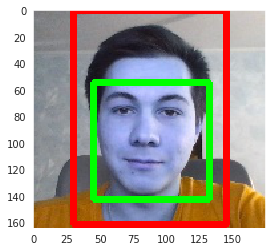

In [6]:
img_tmp = cv2.rectangle(img_input.copy(), (face[0], face[1]), 
                        (face[0] + face[2], face[1] + face[3]),
                        (255, 0, 0), thickness=3, lineType=8, shift=0)
img_tmp = cv2.rectangle(img_tmp, (face_origin[0], face_origin[1]), 
                        (face_origin[0] + face_origin[2], face_origin[1] + face_origin[3]),
                        (0, 255, 0), thickness=3, lineType=8, shift=0)
plt.imshow(img_tmp)

In [7]:
points = [shape[0].tolist(), shape[16].tolist()]
for ix in [4, 12, 8]:
    x, y = shape[ix].tolist()
    points.append((x, y))
    points.append((x, points[0][1] + points[0][1] - y))
    
hull = Delaunay(points)
xy_fg = []
for x, y in it.product(range(img_input.shape[0]), range(img_input.shape[1])):
    if hull.find_simplex([y, x]) >= 0:
        xy_fg.append((x, y))
print('xy_fg%:', len(xy_fg)/np.prod(img_input.shape))

xy_fg%: 0.07871080139372823


In [8]:
r = face[1]*face[3]/np.prod(img_input.shape[:2])
print(r)
k = 0.1

xy_bg_n = int(k*np.prod(img_input.shape[:2]))
print(xy_bg_n)

xy_bg = zip(np.random.uniform(0, img_input.shape[0], size=xy_bg_n).astype(np.int),
            np.random.uniform(0, img_input.shape[1], size=xy_bg_n).astype(np.int))
xy_bg = list(xy_bg)

xy_bg = [(x, y) for (x, y) in xy_bg 
         if y < face[0] or y > face[0] + face[2] or x < face[1] or x > face[1] + face[3]]
print(len(xy_bg)/np.prod(img_input.shape[:2]))

0.0
2870
0.03484320557491289


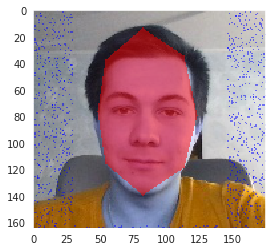

In [9]:
img_tmp = img_input/255.0
for x, y in xy_fg:
    img_tmp[x, y, :] = img_tmp[x, y, :]*0.5 + np.array([1, 0, 0]) * 0.5

for x, y in xy_bg:
    img_tmp[x, y, :] = img_tmp[x, y, :]*0.5 + np.array([0, 0, 1]) * 0.5
    
plt.imshow(img_tmp)

In [10]:
points_fg = np.array([img_input[x, y, :] for (x, y) in xy_fg])
points_bg = np.array([img_input[x, y, :] for (x, y) in xy_bg])

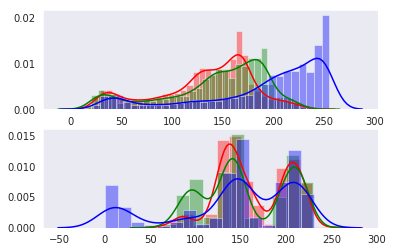

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1)
sns.distplot(points_fg[:, 0], ax=axes[0], color='r')
sns.distplot(points_fg[:, 1], ax=axes[0], color='g')
sns.distplot(points_fg[:, 2], ax=axes[0], color='b')
sns.distplot(points_bg[:, 0], ax=axes[1], color='r')
sns.distplot(points_bg[:, 1], ax=axes[1], color='g')
sns.distplot(points_bg[:, 2], ax=axes[1], color='b')

In [12]:
kde_fg = KernelDensity(kernel='gaussian', 
                       bandwidth=1, 
                       algorithm='kd_tree', 
                       leaf_size=100).fit(points_fg)
kde_bg = KernelDensity(kernel='gaussian', 
                       bandwidth=1, 
                       algorithm='kd_tree', 
                       leaf_size=100).fit(points_bg)

score_kde_fg = np.zeros(img_input.shape[:2])
score_kde_bg = np.zeros(img_input.shape[:2])
likelihood_fg = np.zeros(img_input.shape[:2])
coodinates = it.product(range(score_kde_fg.shape[0]), 
                        range(score_kde_fg.shape[1]))
for x, y in tqdm_notebook(coodinates, 
                          total=np.prod(score_kde_fg.shape)):
    score_kde_fg[x, y] = np.exp(kde_fg.score(img_input[x, y, :].reshape(1, -1)))
    score_kde_bg[x, y] = np.exp(kde_bg.score(img_input[x, y, :].reshape(1, -1)))
    n = score_kde_fg[x, y] + score_kde_bg[x, y]
    if n == 0:
        n = 1
    likelihood_fg[x, y] = score_kde_fg[x, y]/n

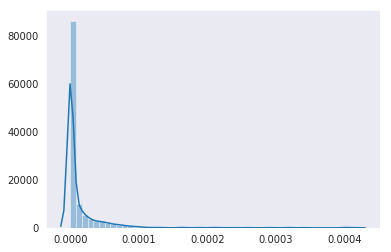

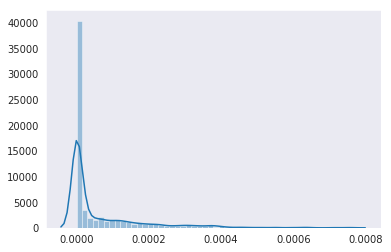

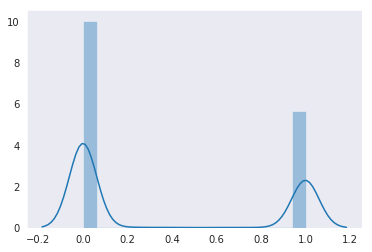

In [13]:
sns.distplot(score_kde_fg.flatten())
plt.show()
sns.distplot(score_kde_bg.flatten())
plt.show()
sns.distplot(likelihood_fg.flatten())
plt.show()

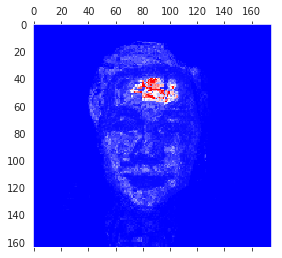

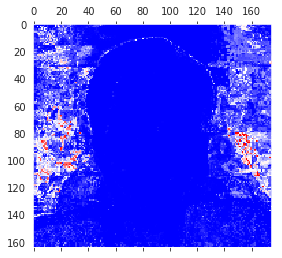

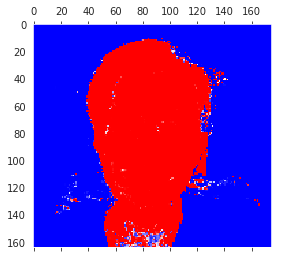

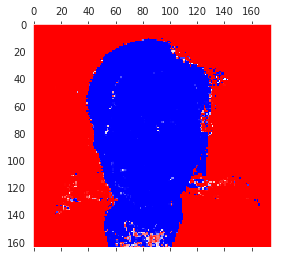

In [14]:
plt.matshow(score_kde_fg, cmap=cm.bwr)
plt.show()
plt.matshow(score_kde_bg, cmap=cm.bwr)
plt.show()
plt.matshow(likelihood_fg, cmap=cm.bwr)
plt.show()
plt.matshow(1 - likelihood_fg, cmap=cm.bwr)
plt.show()

In [15]:
def dijkstra(start_points, w):
    d = np.zeros(w.shape) + np.infty
    v = np.zeros(w.shape, dtype=np.bool)
    q = queue.PriorityQueue()
    for x, y in start_points:
        d[x, y] = 0
        q.put((d[x, y], (x, y)))
    
    for x, y in it.product(range(w.shape[0]), range(w.shape[1])):
        if np.isinf(d[x, y]):
            q.put((d[x, y], (x, y)))
    
    while not q.empty():
        _, p = q.get()
        if v[p]:
            continue

        neighbourhood = []
        if p[0] - 1 >= 0:
            neighbourhood.append((p[0] - 1, p[1]))
        if p[0] + 1 <= w.shape[0] - 1:
            neighbourhood.append((p[0] + 1, p[1]))
        if p[1] - 1 >= 0:
            neighbourhood.append((p[0], p[1] - 1))
        if p[1] + 1 < w.shape[1]:
            neighbourhood.append((p[0], p[1] + 1))

        for x, y in neighbourhood:
            d_tmp = d[p] + np.abs(w[x, y] - w[p])
            if d[x, y] > d_tmp:
                d[x, y] = d_tmp
                q.put((d[x, y], (x, y)))

        v[p] = True
        
    return d

In [16]:
d_fg = dijkstra(xy_fg, likelihood_fg)
d_bg = dijkstra(xy_bg, 1 - likelihood_fg)

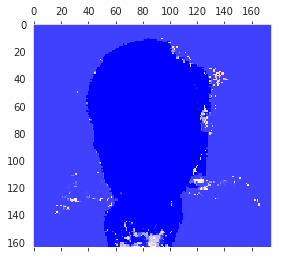

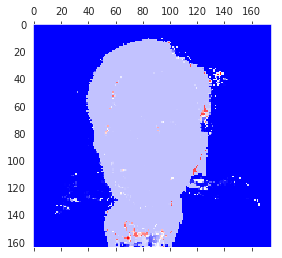

In [17]:
plt.matshow(d_fg, cmap=cm.bwr)
plt.show()
plt.matshow(d_bg, cmap=cm.bwr)
plt.show()

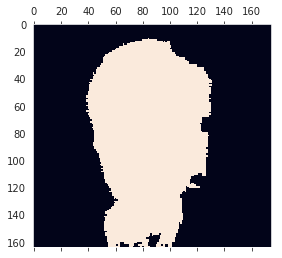

In [18]:
margin = 0.0
mask = (d_fg < (d_bg + margin)).astype(np.uint8)

plt.matshow(mask)
plt.show()

True

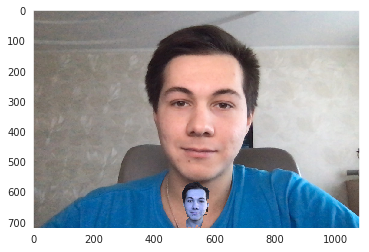

In [19]:
img_fg = img_input/255.0
img_bg = (np.array(Image.open('maxim.jpg'))/255.0)

x = int(img_bg.shape[0] - img_fg.shape[0])
y = int(img_bg.shape[1]/2 - img_fg.shape[1]/2)

img_bg_fg = img_bg[x:(x + img_fg.shape[0]), y:(y + img_fg.shape[1]), :]
mask_3d = np.dstack([mask, mask, mask])
img_bg[x:(x + img_fg.shape[0]), y:(y + img_fg.shape[1]), :] = mask_3d*img_fg + (1 - mask_3d)*img_bg_fg



plt.imshow(img_bg)
cv2.imwrite('_jupiter.jpg', img_bg * 255.0)

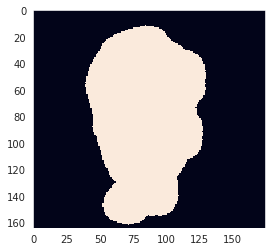

In [20]:
# for r in reversed(range(5, 11)):
#     mask = morphology.opening(mask, morphology.disk(r))
#     mask = morphology.closing(mask, morphology.disk(r))
mask = morphology.opening(mask, morphology.disk(11))
# mask = morphology.closing(mask, morphology.disk(11))


plt.imshow(mask)

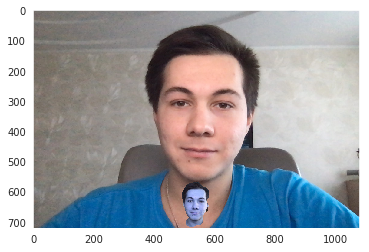

In [21]:
img_fg = img_input/255.0
img_bg = (np.array(Image.open('maxim.jpg'))/255.0)

x = int(img_bg.shape[0] - img_fg.shape[0])
y = int(img_bg.shape[1]/2 - img_fg.shape[1]/2)

img_bg_fg = img_bg[x:(x + img_fg.shape[0]), y:(y + img_fg.shape[1]), :]
mask_3d = np.dstack([mask, mask, mask])
img_bg[x:(x + img_fg.shape[0]), y:(y + img_fg.shape[1]), :] = mask_3d*img_fg + (1 - mask_3d)*img_bg_fg



plt.imshow(img_bg)